In [1]:
library(Seurat)
library(dplyr)
library(tximport)
library(ggplot2)
library(ggsci)
library(harmony)
library(RColorBrewer)
library(tidyverse)
library(pheatmap)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.3     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# *C. roseus* data import and subclustering

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3005
Number of edges: 99853

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8354
Number of communities: 6
Elapsed time: 0 seconds


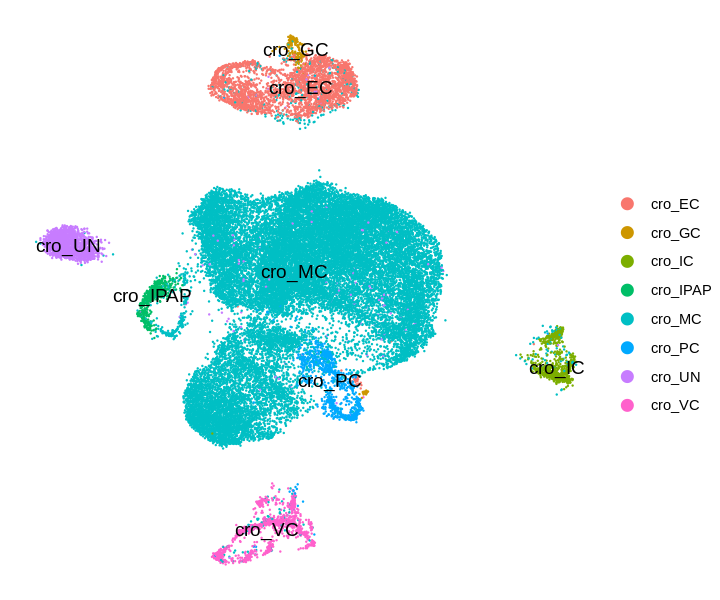

In [2]:
options(repr.plot.height = 5, repr.plot.width = 6)
load(file = "/data/Matthew/scrna/02.Clustering/crov7_alv_mincell5.Rdata")
# new cluster names
new.cluster.ids <- c("MC", "MC", "MC", "MC", "MC",
                     "MC", "EC", "UN", "VC", "EC",
                     "PC", "IC", "IPAP", "MC")

# Add seurat object levels to new.cluster.ids
names(new.cluster.ids) <- levels(seurat_obj)
# Rename clusters
seurat_obj <- RenameIdents(seurat_obj, new.cluster.ids)
seurat_obj[["old.ident"]] <- Idents(object = seurat_obj)

# find sub clusters
for (i in c("EC")) {
  seurat_obj <- FindSubCluster(seurat_obj, cluster = i,
                               graph.name = "RNA_snn",
                               resolution = 0.4,
                               algorithm = 1)
  sub_name <- as.factor(seurat_obj@meta.data$sub.cluster)
  names(sub_name) <- names(seurat_obj@active.ident)
  seurat_obj@active.ident <- sub_name
}
# add name to clusters
seurat_obj[["seurat_clusters"]] <- seurat_obj@active.ident
# new cluster names
new.cluster.ids <- paste("cro_",
    c("EC", "EC", "EC", "EC", "EC", "GC",
      "IC", "IPAP", "MC", "PC", "UN", "VC"), sep = "")
# Add seurat object levels to new.cluster.ids
names(new.cluster.ids) <- levels(seurat_obj)
# Rename clusters
seurat_obj <- RenameIdents(seurat_obj, new.cluster.ids)

DimPlot(seurat_obj, reduction = "umap", label = TRUE) + theme_void()

# *A. thaliana* data import and clustering

## Alevin data import

In [3]:
files <- file.path('/data/Matthew/scrna/sc_align/ath_salmon_leaf/alevin/quants_mat.gz')
txi <- tximport(files, type = "alevin")
ath_1 <- CreateSeuratObject(counts = txi$counts, project = "Ath_Leaf", min.cells = 3)

files <- file.path('/data/Matthew/scrna/sc_align/ath_salmon_shoot1_rep1/alevin/quants_mat.gz')
txi <- tximport(files, type = "alevin")
ath_2 <- CreateSeuratObject(counts = txi$counts, project = "Ath_Shoot_7d1", min.cells = 3)

files <- file.path('/data/Matthew/scrna/sc_align/ath_salmon_shoot1_rep2/alevin/quants_mat.gz')
txi <- tximport(files, type = "alevin")
ath_3 <- CreateSeuratObject(counts = txi$counts, project = "Ath_Shoot_7d2", min.cells = 3)

files <- file.path('/data/Matthew/scrna/sc_align/ath_salmon_shoot4/alevin/quants_mat.gz')
txi <- tximport(files, type = "alevin")
ath_4 <- CreateSeuratObject(counts = txi$counts, project = "Ath_Shoot_14d", min.cells = 3)

reading in alevin gene-level counts across cells with fishpond

reading in alevin gene-level counts across cells with fishpond

reading in alevin gene-level counts across cells with fishpond

reading in alevin gene-level counts across cells with fishpond



## Filtering cells

In [4]:
ath_obj <- merge(x = ath_1, y = c(ath_2, ath_3, ath_4), 
                 add.cell.ids = c("l", "s7d1", "s7d2", "s14d"), project = "ath")
id_path <- "/data/Matthew/scrna/02.Clustering/id_archive_Apr21/"
s.genes <- readLines(paste(id_path, "ath_cellcycle.s.id",sep = "/"))
g2m.genes <- readLines(paste(id_path, "ath_cellcycle.g2m.id",sep = "/"))

ath_obj[["percent.mt"]] <- PercentageFeatureSet(ath_obj, pattern = "^ATMG")
ath_obj[["percent.chl"]] <- PercentageFeatureSet(ath_obj, pattern = "^ATCG")

ath_obj <- subset(
  ath_obj,
  subset =
    nFeature_RNA > 500 &
    nFeature_RNA < 10000 &
    nCount_RNA < 50000 &
    nCount_RNA > 500 &
    percent.mt < 5 &
    percent.chl < 10
)
ath_obj <-
  CellCycleScoring(
    ath_obj,
    s.features = s.genes,
    g2m.features = g2m.genes,
    set.ident = TRUE
  )
ath_obj$CC.Difference <-
  ath_obj$S.Score - ath_obj$G2M.Score

ath_obj <- ath_obj %>%
    NormalizeData() %>%
    FindVariableFeatures() %>%
    ScaleData(vars.to.regress = c("CC.Difference"), verbose = F) %>%
    RunPCA(verbose = F) %>%
    identity()

Warning message:
“The following features are not present in the object: AT3G59765, AT1G78865, AT1G04425, not searching for symbol synonyms”


In [5]:
ath_obj <- RunHarmony(ath_obj, group.by.vars = "orig.ident")

ath_obj <- ath_obj %>%
    RunUMAP(reduction = "harmony", dims = 1:50, verbose = F) %>% 
    FindNeighbors(reduction = "harmony", dims = 1:50, verbose = F) %>% 
    FindClusters(resolution = 0.5, verbose = F) %>% 
    identity()

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony converged after 8 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


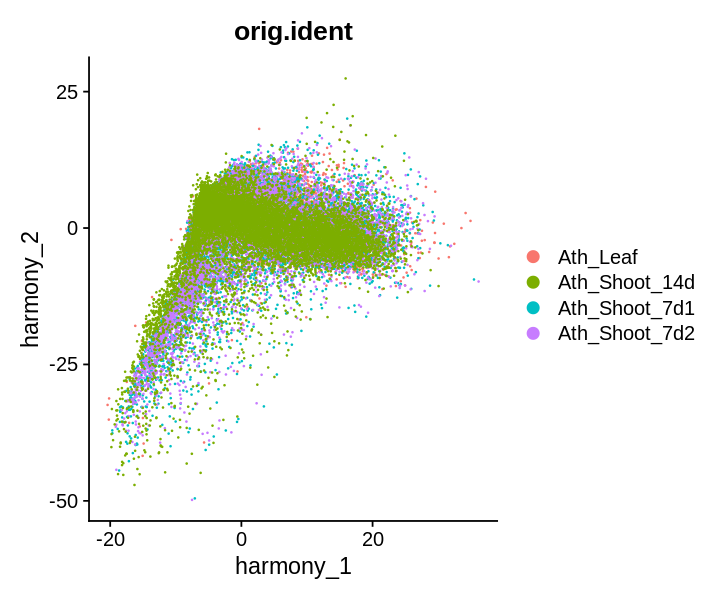

In [6]:
DimPlot(object = ath_obj, reduction = "harmony", pt.size = .1, group.by = "orig.ident")

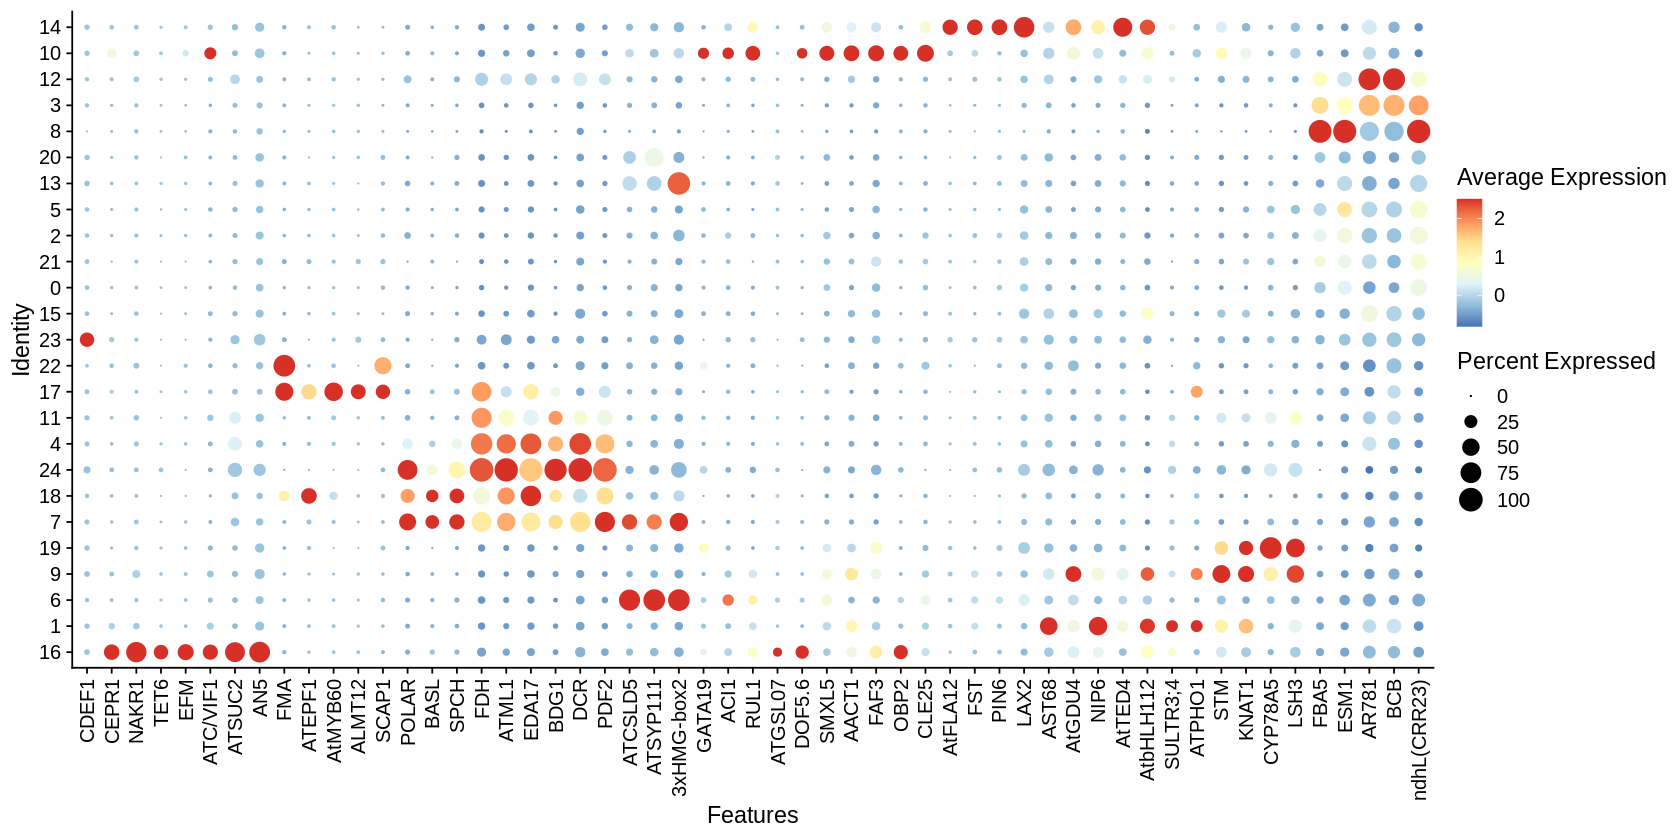

In [7]:
options(repr.plot.height = 7, repr.plot.width = 14)
celltype <- readLines(paste(id_path, 'ath_celltype.id',sep = '/'))
celltype_name <- readLines(paste(id_path, "ath_celltype.name", sep = "/"))
# add scale.by = "size" to increase the size of small dots
DotPlot(ath_obj, features = celltype, cluster.idents = T, cols = "RdYlBu", scale.by = "size") +
  scale_x_discrete(labels = celltype_name) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
ggsave('datacmp_celltype.pdf', width = 14, height = 7)

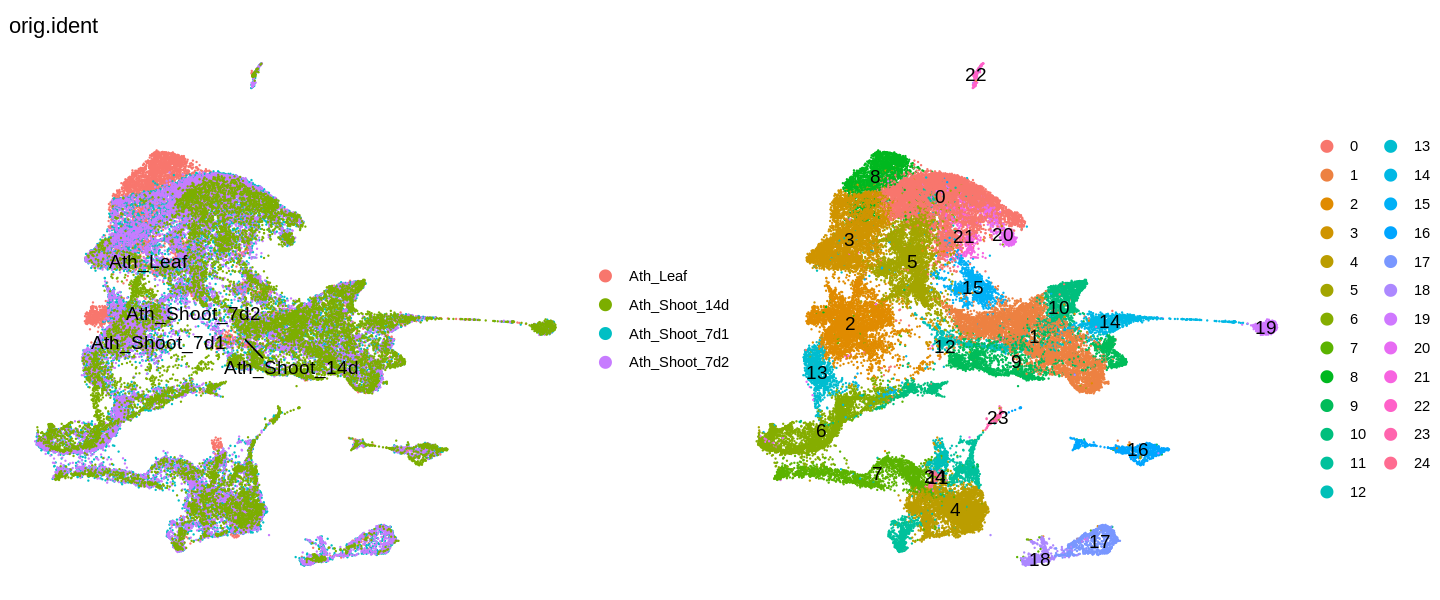

In [8]:
options(repr.plot.height = 5, repr.plot.width = 12)
p1_ath <- DimPlot(ath_obj, reduction = "umap", group.by = "orig.ident",
                  label = TRUE, repel = TRUE) + theme_void()
p2_ath <- DimPlot(object = ath_obj, reduction = "umap", label = T) + theme_void()
p1_ath + p2_ath

In [9]:
# Alevin all ath
new.cluster.ids <- c("ath_MC", "ath_VC", "ath_MC", "ath_MC", "ath_EC",
                     "ath_MC", "ath_PC", "ath_EC", "ath_MC", "ath_SMC",
                     "ath_VC", "ath_EC", "ath_MC", "ath_PC", "ath_VC",
                     "ath_VC", "ath_CC", "ath_GC", "ath_EC", "ath_SMC",
                     "ath_PC", "ath_MC", "ath_GC", "ath_CC", "ath_EC")

# Add seurat object levels to new.cluster.ids
names(new.cluster.ids) <- levels(ath_obj)
# Rename clusters
ath_obj <- RenameIdents(ath_obj, new.cluster.ids)
ath_obj[["old.ident"]] <- Idents(object = ath_obj)

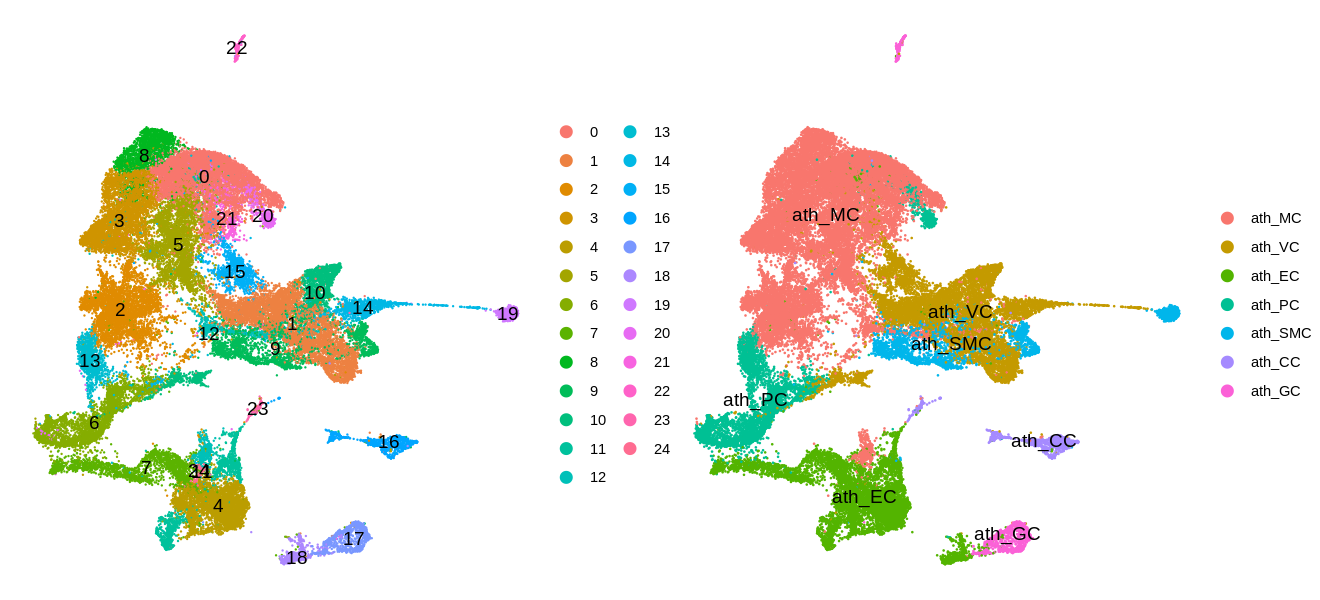

In [10]:
options(repr.plot.height = 5, repr.plot.width = 11)
# t-SNE plot
# TSNEPlot(seurat_obj,label = TRUE) + scale_colour_futurama()
p_ath_umap <- DimPlot(ath_obj, reduction = "umap", label = TRUE, pt.size = 0.1) + theme_void()
p2_ath + p_ath_umap
ggsave("datacmp_umap.png", width = 11, height = 5, dpi = 300)

In [11]:
ath_exp <- AverageExpression(ath_obj)
cro_exp <- AverageExpression(seurat_obj)

ath_index <- ath_exp$RNA %>% 
  as.data.frame() %>% 
  rownames_to_column(var = "ath_id") %>% 
  as_tibble() %>% 
  rowwise() %>%
  mutate(
    mean_gC = sum(c_across(ath_VC:ath_CC)) / 7,
    MC_ath = ath_MC / mean_gC,
    EC_ath = ath_EC / mean_gC,
    GC_ath = ath_GC / mean_gC,
    VC_ath = ath_VC / mean_gC,
    CC_ath = ath_CC / mean_gC,
    PC_ath = ath_PC / mean_gC,
    SMC_ath = ath_SMC / mean_gC
  ) %>%
  select(ath_id, MC_ath:SMC_ath) %>% 
  identity()

cro_index <- cro_exp$RNA %>%
  as.data.frame() %>% 
  rownames_to_column(var = "cro_id") %>% 
  as_tibble() %>% 
  rowwise() %>%
  mutate(
    mean_gC = sum(c_across(cro_EC:cro_VC)) / 8,
    MC_cro = cro_MC / mean_gC,
    UN_cro = cro_UN / mean_gC,
    PC_cro = cro_PC / mean_gC,
    IPAP_cro = cro_IPAP / mean_gC,
    IC_cro = cro_IC / mean_gC,
    EC_cro = cro_EC / mean_gC,
    VC_cro = cro_VC / mean_gC,
    GC_cro = cro_GC / mean_gC
  ) %>%
  select(cro_id, MC_cro:GC_cro) %>% 
  identity()

In [12]:
head(cro_index)

cro_id,MC_cro,UN_cro,PC_cro,IPAP_cro,IC_cro,EC_cro,VC_cro,GC_cro
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EVM0032325,0.7233394,2.0460093,0.5234269,0.9685501,0.22118376,1.107042,0.9153737,1.4950753
EVM0015844,0.5444073,1.0631637,0.2975833,1.0591179,0.00318724,2.373298,1.9962999,0.6629429
EVM0031208,0.6703584,0.2568952,0.1560066,2.3686686,0.00000000,1.363727,0.0000000,3.1843442
EVM0000976,0.9367290,0.2519521,0.8434863,0.7799890,1.24140100,1.294657,1.0194200,1.6323655
EVM0034578,1.1184842,0.3956646,0.8249599,0.7988576,0.93426043,1.211669,1.3166262,1.3994786
EVM0033217,1.1106255,0.2666216,0.2736164,1.1048073,0.79216738,1.073398,1.7709624,1.6078015


In [13]:
rbh <- read.table(paste(id_path, 'cro_ath.tsv',sep = '/'), col.names = c("cro_id", "ath_id")) %>% as_tibble()

cro_sub_index <- left_join(rbh, cro_index)
ath_sub_index <- left_join(rbh, ath_index)

cor_spearman <-
  left_join(cro_sub_index, ath_sub_index) %>% 
  select(-c("cro_id","ath_id")) %>%
  drop_na() %>%
  cor(method = 'spearman') %>%
  identity()

cor_spearman

Joining, by = "cro_id"

Joining, by = "ath_id"

Joining, by = c("cro_id", "ath_id")



,MC_cro,UN_cro,PC_cro,IPAP_cro,IC_cro,EC_cro,VC_cro,GC_cro,MC_ath,EC_ath,GC_ath,VC_ath,CC_ath,PC_ath,SMC_ath
MC_cro,1.000000000,0.609836545,0.01742039,0.44808831,0.28669553,-0.03002405,-0.36775825,-0.32520537,0.352315299,-0.11158083,0.11330910,0.0783307359,0.0711121683,0.18381639,0.008291355
UN_cro,0.609836545,1.000000000,-0.03290769,0.36668128,0.26420217,-0.05923464,-0.31889172,-0.25081241,0.310066952,-0.11599234,0.11221798,0.0956788378,0.0858056244,0.12833259,0.002432374
PC_cro,0.017420389,-0.032907691,1.00000000,0.01647717,-0.04833996,-0.25928589,-0.02644794,-0.15540876,0.197478607,0.11024707,-0.16579225,-0.2283563423,-0.1785410554,0.44156678,-0.030052460
IPAP_cro,0.448088311,0.366681283,0.01647717,1.00000000,0.22538133,-0.18438426,-0.19457979,-0.21197755,0.286432550,-0.10789070,0.10587317,0.0887317414,0.0959438740,0.17478226,0.048117520
IC_cro,0.286695535,0.264202168,-0.04833996,0.22538133,1.00000000,-0.14719736,-0.16296580,-0.27381723,0.280588909,-0.09623801,0.15743947,0.1216363469,0.0977328874,0.13529061,0.046140220
EC_cro,-0.030024052,-0.059234640,-0.25928589,-0.18438426,-0.14719736,1.00000000,-0.10052406,0.27855922,-0.164276302,0.26227449,0.13551731,0.0576914814,-0.0312059761,-0.25442758,0.102329236
VC_cro,-0.367758248,-0.318891718,-0.02644794,-0.19457979,-0.16296580,-0.10052406,1.00000000,-0.01949160,-0.229262007,0.02845478,-0.06765413,0.0468122529,0.1294341568,-0.10588291,0.090423245
GC_cro,-0.325205372,-0.250812415,-0.15540876,-0.21197755,-0.27381723,0.27855922,-0.01949160,1.00000000,-0.144458914,0.25392134,0.19568624,-0.0211257586,-0.0126363397,-0.08736085,0.079760469
MC_ath,0.352315299,0.310066952,0.19747861,0.28643255,0.28058891,-0.16427630,-0.22926201,-0.14445891,1.000000000,0.05119582,0.14146070,0.0076348639,-0.0361298406,0.45955292,-0.005593527
EC_ath,-0.111580828,-0.115992340,0.11024707,-0.10789070,-0.09623801,0.26227449,0.02845478,0.25392134,0.051195815,1.00000000,0.21364837,-0.2684052973,-0.3063823074,0.07210602,-0.081850878


In [15]:
pheatmap(cor_spearman[9:15,1:8],
         display_numbers = T,
#          fontsize = 14,
         cluster_cols = F,
         cluster_rows = F,
         cellwidth = 40,
         cellheight = 40,
         angle_col = 0,
         filename = "datacmp.heatmap.pdf")

# Transform ID, from EVM to AT

In [16]:
rbh <- read.table(paste(id_path, "cro_ath.tsv", sep = "/"))
cro_obj <- subset(seurat_obj, features = rbh$V1)
cro_count_mat <- GetAssayData(cro_obj, slot = "count")
cro_count_mat@Dimnames[[1]] <- filter(rbh, V1 %in% rownames(cro_obj))$V2
cro_trans_id_obj <- CreateSeuratObject(counts = cro_count_mat,
                                       project = "C.roseus")
cro_trans_id_obj[["old.ident"]] <- FetchData(cro_obj, var = "ident")
ath_sub_obj <- subset(ath_obj, features = rbh$V2)

In [17]:
obj.merge <- merge(ath_sub_obj, y = cro_trans_id_obj, add.cell.ids = c("ath", "cro"), project = "ath_cro")
obj.list <- SplitObject(obj.merge, split.by = "orig.ident")
obj.list

$Ath_Leaf
An object of class Seurat 
11179 features across 6861 samples within 1 assay 
Active assay: RNA (11179 features, 0 variable features)

$Ath_Shoot_7d1
An object of class Seurat 
11179 features across 16080 samples within 1 assay 
Active assay: RNA (11179 features, 0 variable features)

$Ath_Shoot_7d2
An object of class Seurat 
11179 features across 15991 samples within 1 assay 
Active assay: RNA (11179 features, 0 variable features)

$Ath_Shoot_14d
An object of class Seurat 
11179 features across 12381 samples within 1 assay 
Active assay: RNA (11179 features, 0 variable features)

$cro1
An object of class Seurat 
11179 features across 8510 samples within 1 assay 
Active assay: RNA (11179 features, 0 variable features)

$cro2
An object of class Seurat 
11179 features across 15813 samples within 1 assay 
Active assay: RNA (11179 features, 0 variable features)

$cro3
An object of class Seurat 
11179 features across 10069 samples within 1 assay 
Active assay: RNA (11179 features,

In [18]:
obj.list <- lapply(X = obj.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})
features <- SelectIntegrationFeatures(object.list = obj.list)
obj.anchors <- FindIntegrationAnchors(object.list = obj.list, anchor.features = features)
# this command creates an 'integrated' data assay
obj.combined <- IntegrateData(anchorset = obj.anchors)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 20204 anchors

Filtering anchors

	Retained 3811 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 20293 anchors

Filtering anchors

	Retained 3840 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 42823 anchors

Filtering anchors

	Retained 30661 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 16498 anchors

Filtering anchors

	Retained 2844 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 26907 anchors

Filtering anchors

	Retained 16539 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 26456 anchors

Filtering anchors

	Retained 15189 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 19148 anchors

Filtering anchors

	Retain

In [19]:
# specify that we will perform downstream analysis on the corrected data note that the original
# unmodified data still resides in the 'RNA' assay
DefaultAssay(obj.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
obj.combined <- ScaleData(obj.combined, verbose = FALSE)
obj.combined <- RunPCA(obj.combined, npcs = 50, verbose = FALSE)
obj.combined <- RunUMAP(obj.combined, reduction = "pca", dims = 1:50, verbose = FALSE)
obj.combined <- RunTSNE(obj.combined, reduction = "pca", dims = 1:50)
obj.combined <- FindNeighbors(obj.combined, reduction = "pca", dims = 1:50, verbose = FALSE)
obj.combined <- FindClusters(obj.combined, resolution = 0.3, verbose = FALSE)

In [20]:
save(obj.combined, file = '/data/Matthew/scrna/02.Clustering/cro_cmb_compare.Rdata')

In [21]:
# load(file = '/data/Matthew/scrna/02.Clustering/compare_Aug1.Rdata')

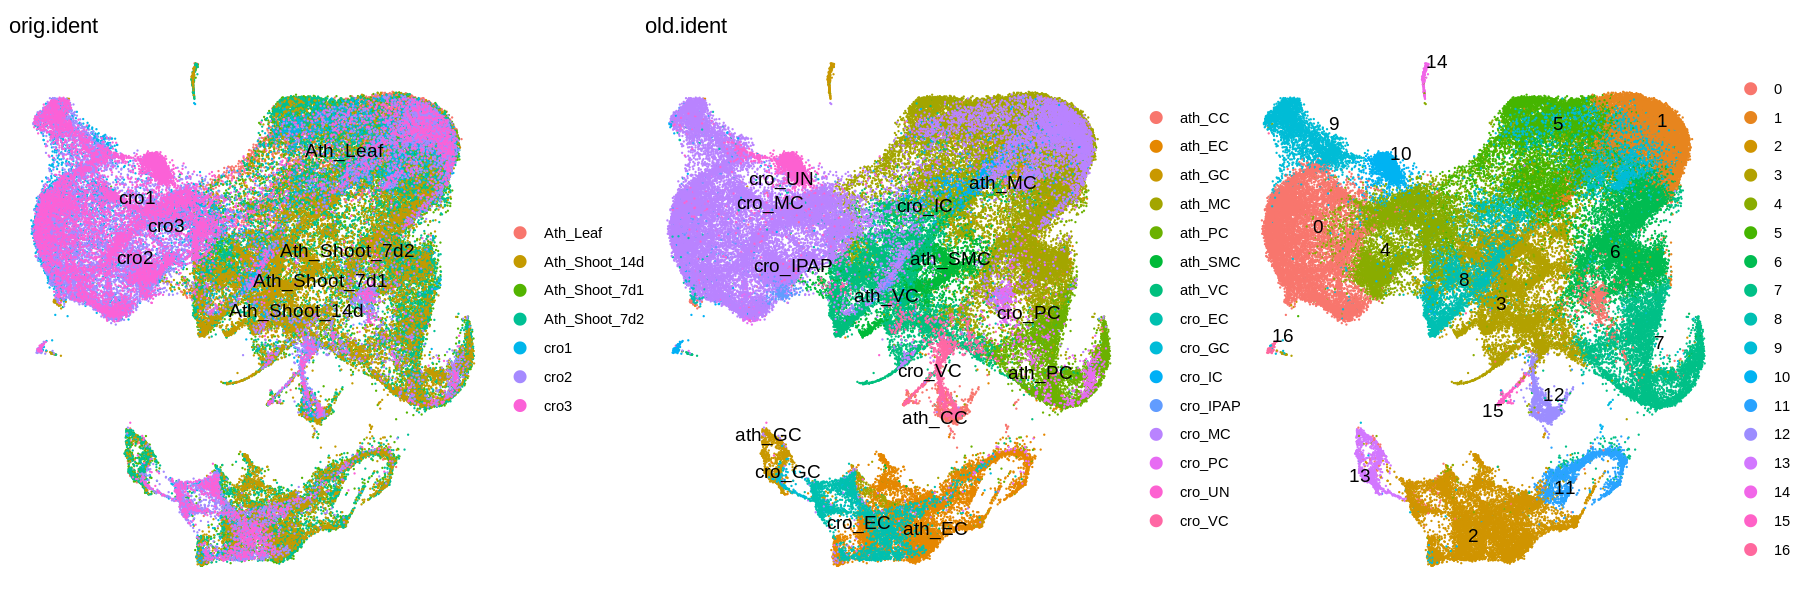

In [22]:
options(repr.plot.height = 5, repr.plot.width = 15)
# Visualization
p1 <- DimPlot(obj.combined, reduction = "umap", group.by = "orig.ident",
        label = TRUE, repel = TRUE) + theme_void()
p2 <- DimPlot(obj.combined, reduction = "umap", group.by = "old.ident",
        label = TRUE, repel = TRUE) + theme_void()
p3 <- DimPlot(obj.combined, reduction = "umap", 
              label = TRUE, repel = TRUE) + theme_void()
p1 + p2 + p3

In [29]:
palath[2:8]

[1] "#C6DBEF" "#9ECAE1" "#6BAED6" "#4292C6" "#2171B5" "#084594" NA

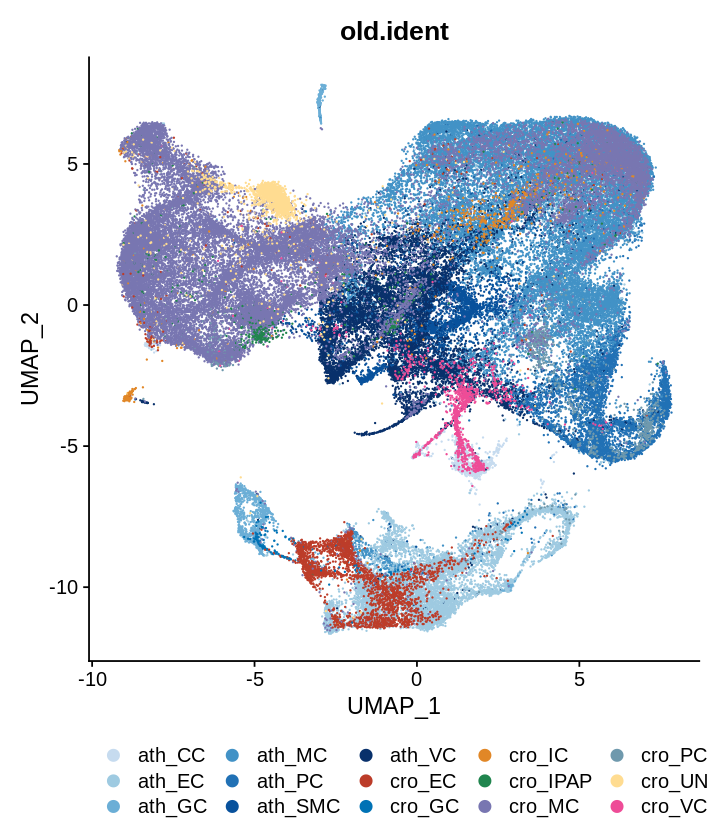

In [34]:
options(repr.plot.height = 7, repr.plot.width = 6)
palath <- brewer.pal(9, "Blues")
palcro <- pal_nejm()(8)


DimPlot(obj.combined, reduction = "umap", group.by = "old.ident", 
        label = F, repel = TRUE, cols = c(palath[3:9], palcro)) + theme(legend.position="bottom")

In [35]:
ggsave("datacmp_umpa.png", dpi = 600, width = 6, height = 7)
ggsave("datacmp_umpa.pdf", width = 6, height = 7)

In [31]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/Matthew/miniconda3/envs/psdtime/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] harmony_1.0        Rcpp_1.0.7         plotly_4.9.4.1     ggsci_2.9         
[5] ggplot2_3.3.5      tximport_1.18.0    dplyr_1.0.7        SeuratObject_4.0.2
[9] Seurat_4.0.3      

loaded via a namespace (and not attached):
  [1] Rtsne_0.15                  colorspace_2.0-2           
  [3] deld